In [1]:
import math
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, GaussianBlur
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF

# MedMNIST import
import medmnist
from medmnist import INFO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- MedMNIST Data setup ---
data_flag = 'chestmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
# Download datasets
train_dataset = DataClass(split='train', download=True)
# test_dataset  = DataClass(split='test' , download=True)   

# Train / test
numSamples = int(0.8 * len(train_dataset))
# numTest    = len(test_dataset)                          

Using device: cuda
Using downloaded and verified file: C:\Users\alexr\.medmnist\chestmnist.npz


In [2]:

# Prepare data tensors 
def _get_tensor(ds, n):
    """Stack first n samples, convert to float32 in [0,1]."""
    imgs = []
    for i in range(n):
        x, _ = ds[i]
        if isinstance(x, torch.Tensor):
            t = x.float() / 255.0
        elif isinstance(x, np.ndarray):
            t = torch.from_numpy(x).float() / 255.0
            if t.ndim == 3:
                t = t.permute(2, 0, 1)
        else:
            t = TF.to_tensor(x)
        imgs.append(t[0])
    return torch.stack(imgs).to(device)

# Load and prepare dataset
X_raw = _get_tensor(train_dataset, numSamples)  # (N, H, W)

dim = X_raw[0].numel()  # e.g. 28*28 = 784
r = 25  # bottleneck / testing rank

# -----------------------------------------------------------------------------
# Compute data statistics based on theorem
# -----------------------------------------------------------------------------

# Reshape data to (n, N)
X = X_raw.view(numSamples, -1).T  # (dim, numSamples)
gammaX = 1 / (numSamples) * X @ X.T
# Compute empirical mean (mu_X) BEFORE centering
#mu_X = X_flat.mean(dim=1, keepdim=True)  # (dim,1)

# Centered data matrix for covariance calculation
#X_centered = X_flat - mu_X  # (dim, numSamples)

# Compute empirical covariance (with small ridge regularization)
#gammaX = torch.cov(X_centered, correction=1) + 1e-5 * torch.eye(dim, device=device)

# Condition number of gammaX
cond_gammaX = torch.linalg.cond(gammaX)
print(f"Condition number of gammaX: {cond_gammaX:.2e}")

# Cholesky factorization: gammaX = K_X @ K_X.T
K_X = torch.linalg.cholesky(gammaX)  # (dim, dim)

# Perform SVD of K_X as in proof
U, D, Vh = torch.linalg.svd(K_X)  # K_X = U D V^T

# Construct optimal rank-r projection matrix A_r = U_r U_r^T
U_r = U[:, :r]  # top r left singular vectors
A_r = U_r @ U_r.T


# Condition number of A_r
cond_A_r = torch.linalg.cond(A_r)
print(f"Condition number of A_r (rank-{r} projection): {cond_A_r:.2e}")

# -----------------------------------------------------------------------------
# Theoretical error: average per-sample l2 discrepancy ------------------------
X_recon = A_r @ X # Reconstruct each sample

# Compute difference and per-sample L2 error
diffs_opt = X_recon - X
rel_error_theory_train = torch.norm(diffs_opt, dim=0).mean().item()  # average over samples

print(f"Theoretical average per-sample L2 training error: {rel_error_theory_train:.4f}")

Condition number of gammaX: 1.10e+08
Condition number of A_r (rank-25 projection): 1.79e+11
Theoretical average per-sample L2 training error: 1.4206


Final average per-sample L2 training error (learned): 11.5951


C:\Users\alexr\AppData\Local\Temp\ipykernel_31432\384192743.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


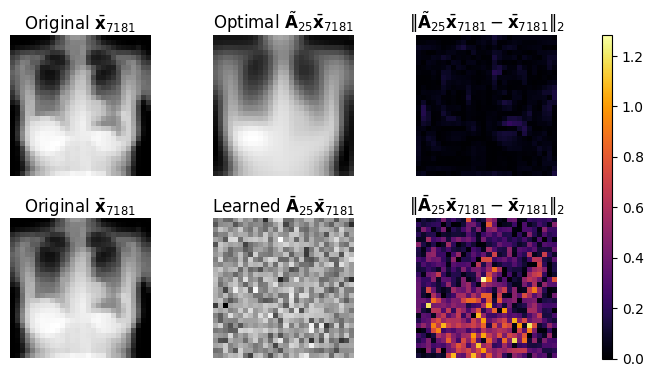

In [3]:
# --- Autoencoder setup -------------------------------------------------------
batch_size = 128
num_epochs = 25

# Define Linear Autoencoder model
class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, bottleneck_dim, bias=False)
        self.decoder = nn.Linear(bottleneck_dim, input_dim, bias=False)

    def forward(self, x):
        return self.decoder(self.encoder(x))

# Instantiate model, optimizer, and loss
model     = LinearAutoencoder(input_dim=dim, bottleneck_dim=r).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Prepare training data tensors
X_tensor = X.T  # Shape (numSamples, dim)
Y_tensor = X.T  # Here using X as both input/output since this is the identity reconstruction problem

# Training loop using average per-sample L2 error -----------------------------
train_errors = []
for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()

    outputs = model(Y_tensor)
    target  = X_tensor

    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()

    # Evaluate and store error after each epoch
    with torch.no_grad():
        A_learned = model.decoder.weight @ model.encoder.weight

        diffs = A_learned @ X - X
        avg_l2_err = torch.norm(diffs, dim=0).mean().item()  # average per-sample l2 discrepancy

        train_errors.append(avg_l2_err)

print(f"Final average per-sample L2 training error (learned): {train_errors[-1]:.4f}")

# --- Compact 2×2 gallery comparing Optimal vs Learned reconstructions --------
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap

everforest_colors = [
    "#2d353b", "#3d484d", "#4f585e", "#566358", "#5a6f47",
    "#7a9c58", "#a7c080", "#dbbc7f", "#e69875", "#e67e80", "#dc5456"
]

everforest_cmap = LinearSegmentedColormap.from_list(
    'everforest_blend',
    everforest_colors,
    N=256
)

# Example sample index for plotting
idx = 7181

# Prepare images for plotting
x_img = X_raw[idx].view(28, 28).cpu()

opt_img   = (A_r @ X)[:, idx].view(28, 28).cpu()
learn_img = (A_learned @ X)[:, idx].view(28, 28).cpu()

# Errors
err_opt   = torch.abs(opt_img   - x_img)
err_learn = torch.abs(learn_img - x_img)
err_vmin, err_vmax = 0.0, max(err_opt.max(), err_learn.max()).item()

# Create 2×3 plot grid (Original | Reconstruction | Errors)
fig = plt.figure(figsize=(8, 4.2))
gs  = gridspec.GridSpec(
    2, 4,
    width_ratios=[1, 1, 1, 0.06],
    wspace=0.20, hspace=0.30
)

# row 0, col 0: Original image
ax = fig.add_subplot(gs[0, 0])
ax.imshow(x_img, cmap='gray')
ax.set_title(r'Original $\bar{\mathbf{x}}_{7181}$', pad=4)
ax.axis('off')

# row 0, col 1: Optimal reconstruction
ax = fig.add_subplot(gs[0, 1])
ax.imshow(opt_img, cmap='gray')
ax.set_title(r'Optimal $\tilde{\mathbf{A}}_{25} \bar{\mathbf{x}}_{7181}$', pad=4)
ax.axis('off')

# row 0, col 2: Optimal error (full norm expression, no bias)
ax = fig.add_subplot(gs[0, 2])
im = ax.imshow(err_opt, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(r'$\|\tilde{\mathbf{A}}_{25} \bar{\mathbf{x}}_{7181} - \bar{\mathbf{x}}_{7181}\|_2$', pad=4)
ax.axis('off')

# row 1, col 0: Original image again
ax = fig.add_subplot(gs[1, 0])
ax.imshow(x_img, cmap='gray')
ax.set_title(r'Original $\bar{\mathbf{x}}_{7181}$', pad=4)
ax.axis('off')

# row 1, col 1: Learned reconstruction
ax = fig.add_subplot(gs[1, 1])
ax.imshow(learn_img, cmap='gray')
ax.set_title(r'Learned $\bar{\mathbf{A}}_{25} \bar{\mathbf{x}}_{7181}$', pad=4)
ax.axis('off')

# row 1, col 2: Learned error (full norm expression, no bias)
ax = fig.add_subplot(gs[1, 2])
ax.imshow(err_learn, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(r'$\|\bar{\mathbf{A}}_{25} \bar{\mathbf{x}}_{7181} - \bar{\mathbf{x}}_{7181}\|_2$', pad=4)
ax.axis('off')

# color-bar
cax = fig.add_subplot(gs[:, 3])
plt.colorbar(im, cax=cax)
cax.yaxis.tick_right()

plt.tight_layout()
plt.show()


In [11]:
# ════════════════════════════════════════════════════════════════════════════
# MULTI-DATASET RANK SWEEP – AFFINE LINEAR
#   • Computes Bayes–optimal rank-r projection matrix A_r and bias b
#   • Learns encoder/decoder + bias using linear autoencoder
#   • Saves pickles with {optimalMatrix, encoderWeight, decoderWeight, biasVector}
#   • Saves final combined plot in AffLinPics/MedMNIST/Tests/
# ════════════════════════════════════════════════════════════════════════════
import os, pickle, torch
from collections import defaultdict
import matplotlib.pyplot as plt

# ── pastel-Everforest colours ───────────────────────────────────────────────
ef_pastel   = ['#a7c080', '#d3869b', "#83c0c0", '#e69875', '#a988b0', "#b8912f"]
line_styles = {'theory': '-',  'learned': '--'}
markers     = {'theory': 'o',  'learned': 's'}
lw, ms      = 1.5, 4

# ── where to stash matrices and final plots ─────────────────────────────────
save_root = "ClassicPics"
matrices_root = os.path.join(save_root, "MedMNIST", "Matrices")
tests_root    = os.path.join(save_root, "MedMNIST", "Tests")
os.makedirs(matrices_root, exist_ok=True)
os.makedirs(tests_root, exist_ok=True)

# ── helper: run rank sweep on ONE MedMNIST subset ───────────────────────────
def run_rank_sweep(data_flag, ranks, train_epochs=500, lr=1e-3):
    """Return ([theory avg l2], [AE avg l2]) for the given dataset
       and store matrices to pickles for every rank."""
    info        = INFO[data_flag]
    DataClass   = getattr(medmnist, info['python_class'])
    train_ds    = DataClass(split='train', download=True)

    numSamples  = len(train_ds)
    X_raw       = _get_tensor(train_ds, numSamples)
    dim         = X_raw[0].numel()

    # --- build mean-centered data X ------------------------------------------
    X = X_raw.view(numSamples, -1).T
    #mu_X   = X_flat.mean(dim=1, keepdim=True)
    #X_c    = X_flat - mu_X  # centered data

    # --- empirical covariance and Cholesky factor K_X -----------------------
    gammaX = (X @ X.T) / (numSamples-1) #+ 1e-5 * torch.eye(dim, device=device)
    #K_X = torch.linalg.cholesky(gammaX)

    # --- SVD of K_X for optimal projection ----------------------------------
    U, D, Vh = torch.linalg.svd(K_X)

    theory_err, learned_err = [], []
    ds_dir = os.path.join(matrices_root, data_flag)
    os.makedirs(ds_dir, exist_ok=True)

    for r in ranks:
        if r % 100 == 0:
            print(f"On Rank {r}")
        # --- Bayes-optimal projection matrix A_r ----------------------------
        U_r = U[:, :r]
        A_r = U_r @ U_r.T
        #b_r = (torch.eye(dim, device=device) - A_r) @ mu_X

        # --- compute optimal reconstruction error ---------------------------
        X_opt = A_r @ X
        diffs_opt = X_opt - X
        avg_l2_opt = torch.norm(diffs_opt, dim=0).mean().item()
        theory_err.append(avg_l2_opt)

        # --- linear autoencoder learning ------------------------------------
        ae = LinearAutoencoder(dim, r).to(device)
        opt = optim.Adam(ae.parameters(), lr=lr)

        for _ in range(train_epochs):
            opt.zero_grad()
            out = ae(X.T)
            loss = criterion(out, X.T)
            loss.backward()
            opt.step()

        with torch.no_grad():
            W_enc = ae.encoder.weight.detach().cpu()
            W_dec = ae.decoder.weight.detach().cpu()
            b_dec = ae.decoder.bias.detach().cpu() if ae.decoder.bias is not None else torch.zeros(dim)
            A_learned = W_dec @ W_enc

            X_learn = A_learned.to(device) @ X
            diffs_learn = X_learn - X
            avg_l2_learn = torch.norm(diffs_learn, dim=0).mean().item()
        learned_err.append(avg_l2_learn)

        # --- save matrices --------------------------------------------------
        dump_path = os.path.join(ds_dir, f"rank_{r:03d}.pkl")
        with open(dump_path, "wb") as f:
            pickle.dump(
                {
                    "optimalMatrix": A_r.cpu(),
                    #"optimalBias":   b_r.cpu(),
                    "encoderWeight": W_enc,
                    "decoderWeight": W_dec,
                    #"biasVector":    b_dec,
                },
                f,
                protocol=pickle.HIGHEST_PROTOCOL,
            )

    return theory_err, learned_err

# ── run all requested datasets ──────────────────────────────────────────────
datasets  = ['breastmnist', 'chestmnist', 'organamnist', 'organcmnist',
             'organsmnist', 'retinamnist']
ranks     = list(range(25, 776, 25))
results   = defaultdict(dict)
num_epochs = 350 # define here for plot naming

for flag in datasets:
    print(f"\n▶ Running rank sweep for {flag} …")
    th, le = run_rank_sweep(flag, ranks, train_epochs=num_epochs)
    results[flag]['theory']  = th
    results[flag]['learned'] = le




▶ Running rank sweep for breastmnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\breastmnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700

▶ Running rank sweep for chestmnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\chestmnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700

▶ Running rank sweep for organamnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\organamnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700

▶ Running rank sweep for organcmnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\organcmnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700

▶ Running rank sweep for organsmnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\organsmnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 7

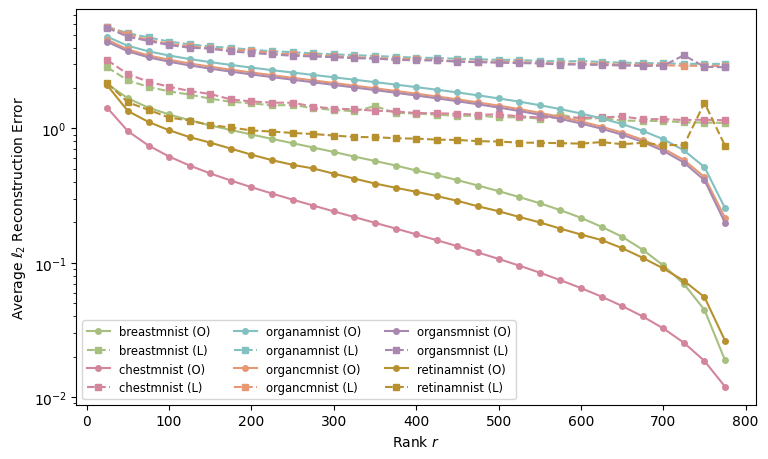

In [ ]:
# ── combined plot -----------------------------------------------------------
plt.figure(figsize=(7.8, 4.7))
short_label = {'theory': 'O', 'learned': 'L'}

for i, flag in enumerate(datasets):
    col = ef_pastel[i % len(ef_pastel)]
    for kind in ('theory', 'learned'):
        plt.plot(ranks,
                 results[flag][kind],
                 line_styles[kind],
                 marker=markers[kind],
                 color=col,
                 lw=lw,
                 ms=ms,
                 label=f"{flag} ({short_label[kind]})")


plt.xlabel('Rank $r$')
plt.ylabel(r'Average $\ell_2$ Reconstruction Error')
plt.yscale('log')
#plt.title('Average $\ell_2$ Error vs. Rank (Affine Linear)')
plt.legend(ncol=3, fontsize='small')
plt.tight_layout()

# Save final plot with shortened name including epoch info
plot_path = os.path.join(tests_root, f"MedMNIST_ClassicRankSweep_{num_epochs}ep.png")
plt.savefig(plot_path)
plt.show()

In [ ]:
# ── Inspect stored matrices & compare singular values (4 decimals) ─────────
#    • Lists datasets / ranks, loads each pickle
#    • Computes singular values of
#        – Bayes–optimal map  Mr
#        – Learned map        A = W_dec @ W_enc
#    • Prints top-k singular values (rounded to 4 decimals) and relative ℓ2 error

import os, pickle, torch

base_dir  = "ClassicPics/MedMNIST/Matrices"  # updated save path for Affine Linear sweep
top_k     = 10                              # how many singular values to show
torch.set_printoptions(edgeitems=3, linewidth=120, sci_mode=False)

for dataset in sorted(os.listdir(base_dir)):
    ds_dir = os.path.join(base_dir, dataset)
    if not os.path.isdir(ds_dir):
        continue

    print(f"\n══════════  {dataset.upper()}  ══════════")
    for fname in sorted(fn for fn in os.listdir(ds_dir) if fn.endswith(".pkl")):
        rank   = int(fname.split("_")[1].split(".")[0])        # rank_050.pkl → 50
        fpath  = os.path.join(ds_dir, fname)

        # ── load matrices ───────────────────────────────────────────────────
        with open(fpath, "rb") as f:
            mats = pickle.load(f)

        Mr   = mats["optimalMatrix"]
        Wenc = mats["encoderWeight"]
        Wdec = mats["decoderWeight"]
        bvec = mats["biasVector"]       # also load biasVector if needed later
        A    = Wdec @ Wenc              # learned full map

        # ── singular values ────────────────────────────────────────────────
        s_opt    = torch.linalg.svdvals(Mr)
        s_learn  = torch.linalg.svdvals(A)

        rel_err = torch.norm(s_opt - s_learn) / torch.norm(s_opt)

        # Round singular values to 4 decimal places for print
        s_opt_rounded   = [round(v.item(), 4) for v in s_opt[:top_k]]
        s_learn_rounded = [round(v.item(), 4) for v in s_learn[:top_k]]

        print(f"\n— Rank {rank:3d} —  ({fpath})")
        print(f"Relative ℓ₂ error on singular values: {rel_err:.3e}")
        print(f"Top {top_k} σ(M_r):", s_opt_rounded)
        print(f"Top {top_k} σ(A)  :", s_learn_rounded)

        # Uncomment next lines if you want FULL singular value lists
        # print("\nAll σ(M_r):\n", s_opt.cpu())
        # print("\nAll σ(A):\n",   s_learn.cpu())



══════════  BREASTMNIST  ══════════

— Rank  25 —  (AffLinPics/MedMNIST/Matrices\breastmnist\rank_025.pkl)
Relative ℓ₂ error on singular values: 7.132e-01
Top 10 σ(M_r): [1.0, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999]
Top 10 σ(A)  : [2.0277, 1.9901, 1.9497, 1.9083, 1.8821, 1.8607, 1.8293, 1.8014, 1.7933, 1.7641]

— Rank  50 —  (AffLinPics/MedMNIST/Matrices\breastmnist\rank_050.pkl)
Relative ℓ₂ error on singular values: 4.037e-01
Top 10 σ(M_r): [1.0, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999]
Top 10 σ(A)  : [1.7821, 1.6962, 1.6598, 1.6569, 1.641, 1.6006, 1.5812, 1.5711, 1.5532, 1.5433]

— Rank  75 —  (AffLinPics/MedMNIST/Matrices\breastmnist\rank_075.pkl)
Relative ℓ₂ error on singular values: 3.034e-01
Top 10 σ(M_r): [1.0, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999]
Top 10 σ(A)  : [1.7244, 1.6176, 1.5816, 1.5393, 1.5318, 1.5003, 1.4969, 1.48, 1.4674, 1.4663]

— Rank 100 —  (AffLinPics/MedMNIST/Matric